# Image processing pipeline with Google Cloud Storage python client

In [5]:
cd ../../../../Apps/Python/cams-rio

C:\Users\luisr\Desktop\Repositories\Apps\Python\cams-rio


### Write and upload videos from images - Custom class

In [2]:
import os, cv2
from tempfile import NamedTemporaryFile
# from modules.googlecloudstorage import GCS

class Video:
    
    def write(frames:list, path:str, fps:int=3, codec:str='mp4v', shape:tuple=None):
        if shape is None:
            try: height, width, _ = frames[0].shape; shape = (width, height)
            except: print('WRITE VIDEO ERROR. SHAPE COULD NOT BE DETERMINED.'); return False
        fourcc = cv2.VideoWriter_fourcc(*codec)
        writer = cv2.VideoWriter(path, fourcc, fps, shape)
        for frame in frames: writer.write(frame)
        cv2.destroyAllWindows(); writer.release()
        return True
    
    def __init__(self, ext:str='.mp4', skip=None, gcs=None):
        self.shape = shape
        self.fps = fps
        self.ext = ext
        self.codec = codec
        self.skip = skip
        self.gcs = gcs
                
    def upload(self, frames:list, blob_name:str, bucket_name:str, content_type:str='video/mp4', overwrite:bool=False):
        if not len(frames):
            print(); print(f'VIDEO UPLOAD FAILED. EMPTY FRAME LIST PROVIDED. BLOB: {blob_name} · BUCKET: {bucket_name}')
            return False
        if not overwrite and self.gcs.is_blob_in_bucket(blob_name, bucket_name):
            print(); print(f'VIDEO UPLOAD FAILED. BLOB ALREADY EXISTS. BLOB: {blob_name} · BUCKET: {bucket_name}')
            return False
        with NamedTemporaryFile() as temp:
            tname = f"{temp.name}{self.ext}"
            Video.write(frames, tname)
            self.gcs.upload_from_filename(tname, blob_name, bucket_name, content_type, overwrite=True)
        print(); print(f'VIDEO UPLOAD SUCCESS. BLOB: {blob_name} · BUCKET: {bucket_name}')            
        return True

    def read_images_from_folder(self, folder:str, ext:str='.jpg'):
        '''
        folder: full path to folder containing images.
        '''
        stamp_files = [path for path in os.listdir(folder) if path.endswith(ext)]
        stamp_images = []
        for stamp_file in stamp_files:
            stamp_path = f'{folder}/{stamp_file}'
            image = cv2.imread(stamp_path)
            if image is None:
                print(); print(f'IMAGE READ FAILED. PATH: {stamp_path}')
                continue
            if self.skip is not None and self.skip(image): continue
            stamp_images.append(image)
        return stamp_images

    def read_images_from_bucket(self, prefix:str, delimiter=None, bucket_name:str, ext:str='.jpg'):
        '''
        '''
        blobs = self.gcs.bucket(bucket_name).list_blobs(prefix=prefix, delimiter=delimiter)
        
        files = [blob.name for blob in blobs if blb.name.endswith(ext)]
        images = []
        for file in files:
            path = f'{prefix}/{file}'
            image = cv2.imread(path)
            if image is None:
                print(); print(f'IMAGE READ FAILED. PATH: {stamp_path}')
                continue
            if self.skip is not None and self.skip(image): continue
            stamp_images.append(image)
        return stamp_images

    def upload_from_images(self, folder:str, blob_name:str, bucket_name:str, ext:str='.jpg', content_type:str='video/mp4', overwrite:bool=False):
        if not overwrite and self.gcs.is_blob_in_bucket(blob_name, bucket_name):
            print(); print(f'VIDEO UPLOAD FAILED. BLOB ALREADY EXISTS. BLOB: {blob_name} · BUCKET: {bucket_name}')
            return False
        return self.upload(self.read_images_from_folder(folder, ext), blob_name, bucket_name, content_type, overwrite=True)


---

# Images processing pipeline

### 1. Download blob files to folder

In [53]:
from IPython.display import clear_output as co

#### Google Cloud Storage module

In [51]:
from modules.googlecloudstorage import GCS

sa_json = 'auth/octacity-iduff.json' # 'auth/pluvia-sa.json'
user_project = 'octacity'

gcs = GCS(sa_json, user_project)

#### List blobs in blob

In [21]:
bucket_name = 'city-camera-images'
prefix = 'pics/'
delimiter = None
ext = '.jpg'

blobs = gcs.get_bucket(bucket_name).list_blobs(prefix=prefix, delimiter=delimiter)
# blobs = gcs.list_blobs(bucket_name, prefix, delimiter)

names, images = [], []
for i, blob in enumerate(blobs):
    if i % 500 == 0: print(); print(f'Blobs Searched: {i+1}'); co(True)
    if blob.name.endswith(ext): images.append(blob.name)
    names.append(blob.name)
#     if blob.name.endswith('/'): folders.append(blob.name)

# print(); print(f'Blobs Query: {len(blobs_ext)}/{len(blobs)}')
print(); print(f'Blobs: {len(names)}')


Blobs: 771757


#### File count per folder

    file_count = {
        'pics': '756982',
        'rain': '173601',
    }

#### Download blobs in blob to folder

In [7]:
folder = '../../../Dados/Downloads'
bucket_name = 'city-camera-images'
prefix = 'test/'
delimiter = None

pipeline_download = [
#     'auto/flood',
#     'flood',
#     'manual',
    'rain', # missing
#     'pics', # missing
#     'test',
    
]

for prefix in pipeline_download: gcs.download_to_folder(
    folder, bucket_name, prefix, delimiter, 
    overwrite=False, report_freq=10, skip=82000
)


PREFIX: rain · RUNNING: 145.7 min · RATE: 0.0955 s/file · FINISH-ESTIMATE: 0.0 min · PROGRESS: 173600/173601 · DOWNLOADS: 91324/91601


### 2. Buckets Image and video files processing pipeline

- Read files from disk
- Convert images to video
- Upload to cloud storage bucket

#### Computer vision method settings (Image Similarity)

In [5]:
from modules.image_similarity import similarity_classifier

baseimgs = ['static/gabaritos/cam.jpg', 'static/gabaritos/dark.jpg']

p = 0.05
clf_diff = similarity_classifier(baseimgs, p)

clf_diff.predict_any

from modules.histogram import HistogramClassifier

threshold=0.6
clf_hist = HistogramClassifier(threshold)

C:\Users\luisr\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Set pipeline parameters

In [ ]:
import pandas as pd
from time import time

cameras = pd.read_csv('static/city/cameras.csv')
cameras['Codigo'] = cameras['Codigo'].astype(int)
cameras['cluster_id'] = cameras['cluster_id'].astype(int)
cameras.set_index('Codigo', inplace=True)


# skip = clf_diff.predict_any
skip = clf_hist.is_histogram_clustered
gcs = GCS('auth/octacity-iduff.json', 'octacity')

video = Video(skip=skip, gcs=gcs)

path = '../../../Dados/Downloads'
to_bucket_name = 'flood-video-collection'

pipeline_config = [{ 
#     'event_type': 'auto/flood',
#     'bucket_folder': 'polygons/flood',
#     'blob_type': 'polygon',
#     'upload_from': 'video_file',
# }, {
#     'event_type': 'flood',
#     'bucket_folder': 'polygons/flood',
#     'blob_type': 'polygon',
#     'upload_from': 'image_folder',
# }, {
#     'event_type': 'manual/2023-08-02',
#     'bucket_folder': 'polygons/manual',
#     'blob_type': 'polygon',
#     'upload_from': 'image_folder',
# }, {
#     'local_folder': 'rain', # missing
#     'bucket_folder': 'rain',
#     'blob_type': 'camera',
#     'upload_from': 'image_folder',
#     'skip': 14400,
#     'overwrite': False,
# }, {
    'event_type': 'pics', # missing
    'bucket_folder': 'polygons/flood',
    'blob_type': 'polygon',
    'upload_from': 'image_folder',
}]

# obs. 'event_type' values 'auto/rain', 'comando' and 'waze' were transferred to new bucket manually.

#### Build pipeline parameter list

In [8]:
pipe_params = []

for i, config in enumerate(pipeline_config):

    if 'overwrite' not in config: config['overwrite'] = False
    if 'skip' not in config: config['skip'] = 0
        
    skip = config['skip']
    overwrite = config['overwrite']

    local_folder = config['local_folder'] # Get 'local_folder' folder config
    bucket_folder = config['bucket_folder']
    
    event_folder = f'{path}/{local_folder}' # Get 'local_folder' folder
    event_codes = os.listdir(event_folder)
    
    cnt = 0
    for j, code in enumerate(event_codes): # Get 'local_folder' code
        cnt += 1
        if cnt % 10 == 0: co(True); print(f'CODES: {cnt}/{len(event_codes)}')
        
        if config['blob_type'] == 'polygon':
            polygon_id = cameras.loc[int(code), 'cluster_id']
            
        code_folder = f'{event_folder}/{code}' # Get 'code' folder
        code_stamps = os.listdir(code_folder)
        
        for k, stamp in enumerate(code_stamps): # get 'code' timestamp
            
            if 'blob_type' not in config:
                config['blob_type'] = 'camera'
            if 'upload_from' not in config:
                config['upload_from'] = 'video_file'

            from_folder = f'{code_folder}/{stamp}'
            to_blob_name =  f'{bucket_folder}'
            if config['blob_type'] == 'polygon': to_blob_name += f'/{polygon_id}'
            to_blob_name += f'/{code}'
            to_blob_name += f'/{stamp}' if config['upload_from'] == 'video_file' else f'/CODE{code} {stamp}.mp4'

            pipe_params.append({'folder': from_folder, 'to_blob_name': to_blob_name, 'to_bucket_name': to_bucket_name, 'overwrite': overwrite, 'upload_from': config['upload_from']})
            

CODES: 2830/2834


#### Loop through the pipeline stages

In [35]:
start = time()
for i, config in enumerate(pipeline_config):

    event_type = config['event_type'] # Get 'event_type' folder config
    bucket_folder = config['bucket_folder']
    
    event_folder = f'{path}/{event_type}' # Get 'event_type' folder
    event_codes = os.listdir(event_folder)

    if 'overwrite' not in config: config['overwrite'] = False
    if 'skip' not in config: config['skip'] = 0
    skip = config['skip']
    overwrite = config['overwrite']
    
    n = len(event_codes)
    done, skipped, files = 0, 0, -1
    errors = []
    left = n
    rate = None
    for j, code in enumerate(event_codes): # Get 'event_type' code
        if config['blob_type'] == 'polygon':
            polygon_id = cameras.loc[int(code), 'cluster_id']
            
        code_folder = f'{event_folder}/{code}' # Get 'code' folder
        code_stamps = os.listdir(code_folder)
        
        for k, stamp in enumerate(code_stamps): # get 'code' timestamp
            files += 1
            if files < skip: continue

            if 'blob_type' not in config:
                config['blob_type'] = 'camera'
            if 'upload_from' not in config:
                config['upload_from'] = 'video_file'

            stamp_folder = f'{code_folder}/{stamp}'
            to_blob_name =  f'{bucket_folder}'
            if config['blob_type'] == 'polygon': to_blob_name += f'/{polygon_id}'
            to_blob_name += f'/{code}'
            to_blob_name += f'/{stamp}' if config['upload_from'] == 'video_file' else f'/CODE{code} {stamp}.mp4'

            co(True)
            try:
                if config['upload_from'] == 'video_file':
                    status = video.gcs.upload_from_filename(stamp_folder, to_blob_name, to_bucket_name, content_type='video/mp4', overwrite=overwrite)
                elif config['upload_from'] == 'image_folder':
                    status = video.upload_from_images(
                        stamp_folder, to_blob_name, to_bucket_name,
                        ext='.jpg', content_type='video/mp4', overwrite=overwrite
                    )
                    
            except Exception as err:
                errors.append({'error': str(err), 'config': config['event_type'], 'code': code, 'file': stamp_folder, 'blob': to_blob_name})
            
            if rate is not None:
                expect_total = rate * (n - skipped)
                expect_finish = rate * left
                running_min = round(running / 60, 1)
                expect_total_min = round(expect_total / 60, 1)
                expect_finish_min = round(expect_finish / 60, 1)
                print(); print(f'- PIPELINE: {config["event_type"]} · BLOB: {to_blob_name}')
                print(); print(f'- STAGE: {i+1}/{len(pipeline_config)} · CODES: {done}/{n} · FILES: {k+1}/{len(code_stamps)}')
                print(); print(f'- TOTAL: {files} · ERRORS: {len(errors)}')
                print(); print(f'- RUNNING: {running_min} / {expect_total_min} min · EXPECT-FINISH: {expect_finish_min} min')
        
        running = time() - start
        done += 1; left = n - done
        if files < skip: skipped +=1
        rate = running / (done - skipped) if (done - skipped) != 0 else 0



VIDEO UPLOAD FAILED. EMPTY FRAME LIST PROVIDED. BLOB: rain/990/CODE990 2023-02-10 23-45-01.mp4 · BUCKET: flood-video-collection

- PIPELINE: rain · BLOB: rain/990/CODE990 2023-02-10 23-45-01.mp4

- STAGE: 1/1 · CODES: 2833/2834 · FILES: 6/6

- TOTAL: 17662 · ERRORS: 0

- RUNNING: 29.1 / 29.2 min · EXPECT-FINISH: 0.1 min


#### STOPPED AT SKIP: 6200

### 3. Clean up storage

#### Delete blobs that match provided extension

In [77]:
bucket_name = 'flood-video-collection'
prefix = 'rain/'
delimiter = None

ext = '.mp4.mp4'
# pattern = 'CODE'

blobs = gcs.list_blobs(bucket_name, prefix, delimiter)

blobs_ext = []
for blob_name in blobs:
    
    if blob_name.endswith(ext):
        blobs_ext.append(blob_name)
#     if len(blob_name.split(pattern)) - 1 == 2:
#         blobs_ext.append(blob_name)

print('Blobs:', len(blobs), '· Query:', len(blobs_ext))

bucket = gcs.get_bucket(bucket_name)

deleted = 0
for i, blob in enumerate(bucket.list_blobs(prefix=prefix, delimiter=delimiter)):

    if blob.name.endswith(ext):
        blob.delete(); deleted += 1
#     if len(blob.name.split(pattern)) - 1 == 2:
#         blob.delete(); deleted += 1

    co(True); print(f'Iteration: {i+1}/{len(blobs)} · Deleted: {deleted}/{len(blobs_ext)}')

Iteration: 18/18 · Deleted: 0/0


#### Check result

In [66]:
blobs = gcs.list_blobs(bucket_name, prefix, delimiter)

blobs_ext = []
for blob_name in blobs:
    if blob_name.endswith(ext): blobs_ext.append(blob_name)
#     if len(blob_name.split(pattern)) - 1 == 2: blobs_ext.append(blob_name)

print(f'Blobs: {len(blobs)} · Query: {len(blobs_ext)}')

Blobs: 577 · Query: 0


### 4. Classify images nested in folder

In [ ]:
import os, numpy as np
from time import time
from IPython.display import clear_output as co
from modules.histogram import HistogramClassifier

ext = '.jpg'

threshold = 0.6
clf_hist = HistogramClassifier(threshold)
predict = clf_hist.is_histogram_clustered

n = len(pipe_prams)
labels, fail = [], []; s = time()
for i, params in enumerate(pipe_params):
    if i % 10 == 0 and i != 0:
        run = time() - s
        rate = run / i; left = n - i
        time_total = round(rate * n / 60, 1)
        time_left = round(rate * left / 60, 1)
        co(True); print(f'FILES: {i+1}/{n} · TIME: {round(run/60, 1)} · TIME-LEFT: {time_left}')
    folder = params['folder']
    filenames = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(ext)]
    frames = []
    for filename in filenames:
        img = cv2.imread(filename)
        if img is None:
            fail.append({'error': 'FAIL TO READ', 'filename': filename, **params}); continue
        frames.append(img)
    labels.append(np.all(predict(frames)))

FILES: 8041/17663


---
## 'pics' folder (delete dark images)

In [3]:
import json, pandas as pd

data_path = '../../../Data Science Projects/Hackaton COR IV - Centro de Operações do RJ/INCUBAÇÃO/Cameras/Dados'

### 1. List blobs in 'pics/' blob

In [21]:
bucket_name = 'city-camera-images'
prefix = 'pics/'
delimiter = None
ext = '.jpg'

blobs = gcs.get_bucket(bucket_name).list_blobs(prefix=prefix, delimiter=delimiter)
# blobs = gcs.list_blobs(bucket_name, prefix, delimiter)

names, images = [], []
for i, blob in enumerate(blobs):
    if i % 500 == 0: print(); print(f'Blobs Searched: {i+1}'); co(True)
    if blob.name.endswith(ext): images.append(blob.name)
    names.append(blob.name)
#     if blob.name.endswith('/'): folders.append(blob.name)

# print(); print(f'Blobs Query: {len(blobs_ext)}/{len(blobs)}')
print(); print(f'Blobs: {len(names)}')


Blobs: 771757


### 2. Save blobs information as dataframe

In [15]:
blobs_df = pd.DataFrame({'blob': names})
blobs_df['ext'] = ''
blobs_df['ext'][blobs_df['blob'].str.endswith('/')] = '/'
blobs_df['ext'][blobs_df['blob'].str.endswith('.jpg')] = '.jpg'

display(blobs_df['ext'].value_counts().to_frame('blobs'))

### 3. Reload blobs dataframe

In [159]:
blobs_df_path = f'{data_path}/blobs/pics.csv'

blobs_df = pd.read_csv(blobs_df_path)

### 3.1 Generate blobs control dataset

In [168]:
# blobs_control_df = blobs_df.copy()
# blobs_control_df['status'] = 'UNCHECKED'

# blobs_control_df.to_csv(f'{data_path}/blobs/pics_control.csv', index=False) # save as csv

### 4. Set computer vision methods (Image Similarity)

In [172]:
from modules.image_similarity import similarity_classifier

baseimgs = ['static/gabaritos/cam.jpg', 'static/gabaritos/dark.jpg']

p = 0.05
clf_diff = similarity_classifier(baseimgs, p)
# clf_diff.predict_any

from modules.histogram import HistogramClassifier

threshold=0.6
clf_hist = HistogramClassifier(threshold)
# clf_hist.is_histogram_clustered

### 5. Set Google Cloud Storage module

In [170]:
from modules.googlecloudstorage import GCS

sa_json = 'auth/octacity-iduff.json' # 'auth/pluvia-sa.json'
user_project = 'octacity'

gcs = GCS(sa_json, user_project)

### 6. Delete dark images progressively


- PROGRESS: 5420/711967 (0.8) · TOTAL: 50435/756982 (6.7%)

- RUNNING: 17.1 min · EXPECT-FINISH: 2228.2 min · RATE: 5.3 ops / s

- BLOB: pics/1120/2023-02-07 20:08:37/CODE1120_2023-02-07 20:55:15.jpg

- INITIAL STATUS: UNCHECKED · UPDATE STATUS: VALID



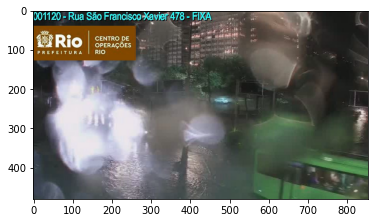

In [ ]:
import cv2

def load_image_from_bytes(bytes_string):
    return cv2.imdecode(np.frombuffer(bytes_string ,dtype=np.uint8), cv2.IMREAD_UNCHANGED)

from time import time
import matplotlib.pyplot as plt

imshow = True

n = 1000
report_freq = 10
# ext = '.jpg'

path_control = f'{data_path}/blobs/pics_control.csv'
bucket_name = 'city-camera-images'

# read status control
blobs_control = pd.read_csv(path_control)

def df_query(data, query):
    df = data.copy()
    for key in query: df = df[df[key]==query[key]]
    return df
    
control = df_query(blobs_control, {'ext': '.jpg', 'status': 'UNCHECKED'})
control_total = df_query(blobs_control, {'ext': '.jpg'})

try:
    n = len(control)
    n_total = len(control_total)
    s = time()
    for i, (index, row) in enumerate(control.iterrows()):
        # get blob
        blob = gcs.get_blob(row['blob'], bucket_name)
        # download
        try:
            # check and delete
            image = load_image_from_bytes(blob.download_as_string())
            status = clf_hist.is_histogram_clustered(image)
            if status: delete = blob.delete()
        except Exception:
            if (i+1) % report_freq == 0:
                print(); print('- MESSAGE: BLOB ALREADY DELETED.')
            image = None; status = True
        # update status
        status_name = 'DELETED' if status else 'VALID'
        blobs_control.loc[index, 'status'] = status_name
        # report
        if (i+1) % report_freq == 0:
            i_total = n_total - n + i + 1
            t = time() - s; rate = t / (i+1)
            left = n - i - 1; t_finish = rate * left
            t_finish = round(t_finish / 60, 1)
            print(); print(f'- PROGRESS: {i+1}/{n} ({round((i+1)/n*100, 1)}) · TOTAL: {i_total}/{n_total} ({round(i_total/n_total*100, 1)}%)')
            print(); print(f'- RUNNING: {round(t/60, 1)} min · EXPECT-FINISH: {t_finish} min · RATE: {round(1/rate, 1)} ops / s')
            print(); print(f'- BLOB: {row["blob"]}')
            print(); print(f'- INITIAL STATUS: {row["status"]} · UPDATE STATUS: {blobs_control.loc[index, "status"]}')
            if imshow and image is not None: print(); plt.imshow(image); plt.show()
            co(True)

except BaseException as err:
    print(); print(f'* EXCEPTION: {err} · BLOB: {row["blob"]} · STATUS: {status}')
    print(); print(f'* PROGRESS: {i+1}/{n} · TOTAL: {i_total}/{n_total}')
    
# save status control
blobs_control.to_csv(path_control, index=False)
print(); print('* BLOBS CONTROL UPDATE SUCCESSFUL')